This code was taken directly from the Python script within the "Random Forest" folder of this project. It was not written with a jupyter notebook in mind, but seems to run okay in this environment. In present form, about half is lifted from Nick's original work, and half is mine (Darren's) addition/modifications.

This script is used to create a random forest model, training days of observed flash flood to several kinematic and thermodynamic variables as forecasted by the NAM BUFR sounding during daylight hours. 

First, we will import a number of common modules

In [194]:
%matplotlib inline
import sys, os
import glob
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score as kappa
import sklearn.ensemble as ens
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import pickle
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV

Now, set some basic parameters, e.g. the years that are available to us in the csv spreadsheet, the sites we will use, the parameters available in the CSV, etc.

In [195]:
availableYears = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

sites = ["K4HV","KBCE","KPGA","KSGU"]

THERMO = ['MUCAPE', 'DCAPE', '7-5LR', 'LCL','PW', 'MeanRH','DD', 'WC', 'SfcTd', 'SfcT']

KIN = ['0-6km Shear Dir', '0-6km Shear Mag', 'C Dn Dir',
       'C Dn Mag', 'C Up Dir', 'C Up Mag', 'SM Dir','SM Mag',
       'MW Dir','MW Mag', '4-6km dir',
       '4-6km mag']

# If a random split is used, different percentages for the testing portion can be used
# Currently, both 'drier' and 'wetter' sites are set to use the same % for testing
drySites = ["K4HV","KSGU"]
drySitesPercentage = 30
wetSitesPercentage = 30
# Default to the wetter sites percentage
percentToTest = wetSitesPercentage

This section sets the various options for the output random forest model. It was designed to be run from a command line, hence the prompts. The prompts still seem to work in this environment, so they have been left as is.

This has been designed so the most commonly used options are the defaults, and they can be achieved by hitting the Enter key. So, basically just hit the enter key a number of times to advance through the prompts.

In [196]:
response = input("Select a method to divide the training data. \n" + \
                 "    Enter '1' for random, '2' or just <enter> for specific years: ")
print('\n')

if len(response) == 0 or response == '2':
   response2 = input("Enter years for training, either comma separated for each year or a range divided by a dash. \n" +
               "    Default is even years for training, or just <enter>: ")
   print('\n')
   if ',' in response2:
      trainingYearsList = list(map(int, response2.split(",")))
   elif '-' in response2:
      firstYear = datetime.strptime(str(response2[0:response2.find('-')]),'%Y')
      secondYear = datetime.strptime(str(response2[response2.find('-')+1:len(response2)]),'%Y')
      trainingYearsList = range(firstYear.year, secondYear.year+1)
   elif len(response2) == 0:
      trainingYearsList = [2008, 2010, 2012, 2014, 2016, 2018, 2020]
   else:
      print("please use the format indicated in the prompts")
      sys.exit()   
   testingYearsList = [x for x in availableYears if x not in trainingYearsList]

response3 = input("Run on each subdivided group of basins (e.g. KSGU) or all at once (KBCE only)?\n" + \
                  "   If running on all at once, you will have the option to run the program iteratively\n" + \
                  "   to obtain a desired skill level.\n" + \
                  "   Enter '1' to see the results for each basin, '2' or just <enter> for all in one:\n ") 
print('\n')
response4 = input("Select a model for the BUFR sounding. \n" + \
                  "   Enter '1' for RAP, '2' or just <enter> for NAM: ")
print('\n')
response5 = input("Display reliability plot of # of flooding vs probabilistic output? \n" + \
                  "   Enter '1' for no, '2' or just <enter> for yes: ")
print('\n')
response6 = input("Calculate stats for RRA and blended RRA/RandomForest? \n" + \
                  "   Enter '1' for no, '2' or just <enter> for yes: ")
print('\n')
response7 = input("Search for optimal hyperparameters (increases runtime)? \n" + \
                  "   Note: 1 season will be subtracted from the training dataset for this\n" + \
                  "   Enter '1' for yes, '2' or just <enter> for no: ")
print('\n') 
response8 = input("Save the Random Forest Model for the RRA tool? \n" + \
                  "   Enter '1' for yes, '2' or just <enter> for no: ")
print('\n')
response9 = input("Use XGBoost in place of standard random forest? \n" + \
                  "   Enter '1' for yes, '2' or just <enter> for no: ")
print('\n')

Select a method to divide the training data. 
    Enter '1' for random, '2' or just <enter> for specific years:  


Enter years for training, either comma separated for each year or a range divided by a dash. 
    Default is even years for training, or just <enter>:  


Run on each subdivided group of basins (e.g. KSGU) or all at once (KBCE only)?
   If running on all at once, you will have the option to run the program iteratively
   to obtain a desired skill level.
   Enter '1' to see the results for each basin, '2' or just <enter> for all in one:
  


Select a model for the BUFR sounding. 
   Enter '1' for RAP, '2' or just <enter> for NAM:  


Display reliability plot of # of flooding vs probabilistic output? 
   Enter '1' for no, '2' or just <enter> for yes:  


Calculate stats for RRA and blended RRA/RandomForest? 
   Enter '1' for no, '2' or just <enter> for yes:  


Search for optimal hyperparameters (increases runtime)? 
   Note: 1 season will be subtracted from the training dataset for this
   Enter '1' for yes, '2' or just <enter> for no:  


Save the Random Forest Model for the RRA tool? 
   Enter '1' for yes, '2' or just <enter> for no:  


Use XGBoost in place of standard random forest? 
   Enter '1' for yes, '2' or just <enter> for no:  


This subroutine handles the creation of reliability plots.

In [197]:
def createReliabilityPlots(site, response5, response6, ytest, yprob, yprob2, yprob3):
      if response5 == '2' or len(response5) == 0:
         clf_score = brier_score_loss(ytest, yprob)
         fraction_of_positives, mean_predicted_value = calibration_curve(ytest, yprob, n_bins=10)
         plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
         plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % ("Random Forest Model for " + site, clf_score))
         plt.legend(loc='best')
         # Add plots for legacy RRA product comparison, if requested
         if response6 == '2' or len(response6) == 0:
            clf_score = brier_score_loss(ytest, yprob2)
            plt.figure() 
            fraction_of_positives, mean_predicted_value = calibration_curve(ytest, yprob2, n_bins=10)
            plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
            plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % ("Legacy RRA", clf_score))
            plt.legend(loc='best')

            clf_score = brier_score_loss(ytest, yprob3)
            plt.figure() 
            fraction_of_positives, mean_predicted_value = calibration_curve(ytest, yprob3, n_bins=10)
            plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
            plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % ("Blended RRA & Random Forest", clf_score))
            plt.legend(loc='best')

The optional subroutine handles tuning of hyperparameters.

In [198]:
def tuneHyperparameters(xtrain, ytrain):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 20000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
                   'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Option to use a 'traditional' random forest, or boosted gradient trees via XGBoost
    if len(response9) == 0 or response9 == '2':
        clf = ens.RandomForestClassifier()
        max_depth.append(None) # Per error message, this seems to only be applicable to the RandomForestClassifier
    elif response9 == '1': 
        import xgboost as xgb
        clf = xgb.XGBClassifier()
    
    clfRandom = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100,
                                   cv = 3, random_state = 42, n_jobs = -1)
    clfRandom.fit(xtrain, ytrain)
    print(clfRandom.best_params_)
    return(clfRandom)

Open the appropriate CSV files for the selected model

In [199]:
if len(response4) == 0 or response4 == '2':
   model = "NAM"
else:
   model = "RAP"

# Allow for the path from either the top level directory, or the Random Forest folder
if os.path.isdir('csv'):
    filePathPreprend = 'csv'
else:
    filePathPreprend = '../csv'

# Open the selected model's csv location
if model == "NAM":
   fileString = filePathPreprend + '/*.csv'
elif model == "RAP":
   fileString = filePathPreprend + '/*full_clean.csv'

This is where the bulk of the work is done. Loop through each CSV, find whether it matches the site of choice, then run the random forest creation.

Using 111 FF cases for KBCE training and 98 cases for testing
Total of 402 training cases and 405 testing cases



FFW model results for KBCE using the NAM, testing on [2009, 2011, 2013, 2015, 2017, 2019]
--Probabilistic Verification--
Brier Score 0.16, AUC = 0.76 
--Deterministic Verification--
Accuracy = 0.76, Cohen's Kappa 0.29
                      No Flooding Forecast  Flooding Forecast
No Flooding Observed                   267                 40
Flooding Observed                       59                 39

SLC RRA verification for KBCE using the NAM, testing on [2009, 2011, 2013, 2015, 2017, 2019]
--Probabilistic Verification--
Brier Score 0.18, AUC = 0.71 
--Deterministic Verification--
Accuracy = 0.74, Cohen's Kappa 0.29
                      No Flooding Forecast  Flooding Forecast
No Flooding Observed                   256                 51
Flooding Observed                       54                 44

SLC combined verification for KBCE using the NAM, testing on [2009, 2011

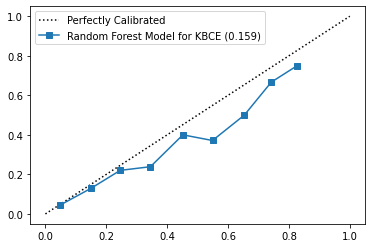

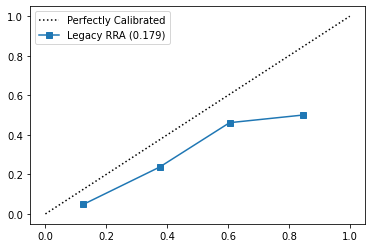

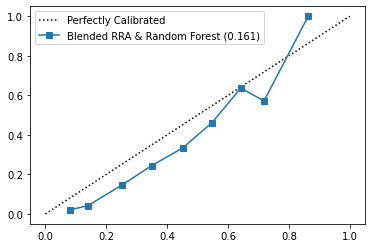

In [200]:
for csv in glob.glob(fileString):
   
    probabilisticOutput = []
    deterministicOutput = []

    # Find the site name and fix if necessary
    if model == "NAM":
       site = csv[-8:-4]
    elif model == "RAP":
       site = csv[-19:-15]
    if '4HV' in site:
       site = 'K4HV'

    # Only use the KBCE site if that's what was requested     
    if response3 == '2' or len(response3) == 0:
       if site != 'KBCE':
          continue

    if site in drySites:
       percentToTest = drySitesPercentage
    else:
       percentToTest = wetSitesPercentage

    df = pd.read_csv(csv)

    # Build a Results column if it doesn't exist already
    if 'Result' not in df.columns:
        df['Result'] = np.nan
        df.loc[(df['Basins'] == 0), 'Result'] = 0     
    
    # Assign a value for the Results column (the predictand) based on the number of basins flooding

    # The code below is what we originally intended to train the model on
    # However, it reduces the number of cases significantly and causes the model to overfit
    #if site == 'KBCE':   
    #    df.loc[(df['Basins'] >= 3), 'Result'] = 1
    #elif site == "K4HV" or site == "KSGU":   
    #    df.loc[(df['Basins'] >= 1), 'Result'] = 1      
    #elif site == "KPGA":       
    #    df.loc[(df['Basins'] >= 2), 'Result'] = 1
    
    # Because the code above is quite limiting, the alternative is to train each area to 1 or more basins flooding
    df.loc[(df['Basins'] >= 1), 'Result'] = 1 
    
    # Filter out May/June/October as those months do not feature as many flash flood days
    df.loc[(df['Month'] == 5), 'Result'] = np.nan
    df.loc[(df['Month'] == 6), 'Result'] = np.nan
    df.loc[(df['Month'] == 10), 'Result'] = np.nan
    
    # Filter out cases of dewpoint depression > 20C since those are probably obvious non-flooding days
    df.loc[(df['DD'] >= 20), 'Result'] = np.nan
    
    # Make a new dataframe that removes any dates with missing entries, set up the predictor & predictands   
    df2 = df.dropna(subset=KIN + THERMO + ['Basins'] + ['Result'] + ['deterministicRRA'] + ['probabilisticRRA'])  
    result = df2['Result']
    predictors = df2[THERMO + KIN]

    # Random split of dates option, otherwise use fixed dates
    if response == '1': 
        xtrain, xtest, ytrain, ytest = train_test_split(predictors, result, test_size = percentToTest/100)
        test_df = df.iloc[xtest.index.tolist()]
    elif len(response) == 0 or response == '2':
        # Slightly convoluted way to use the years the user specifies
        training_df = df2
        test_df = df2
        for year in testingYearsList:
            training_df = training_df[training_df['Year'] != year]
        for year in trainingYearsList:
            test_df = test_df[test_df['Year'] != year]
        xtrain = training_df[THERMO + KIN]
        xtest = test_df[THERMO + KIN]
        ytrain = training_df['Result']
        ytest = test_df['Result']

    # Print out a list of how many cases are being used in training/testing
    print('Using ' + str(int(ytrain.sum())) + ' FF cases for ' + site + ' training and ' + str(int(ytest.sum())) + ' cases for testing')
    print('Total of ' + str(len(training_df)) + ' training cases and ' + str(len(test_df)) + ' testing cases')
        
    # Create a random forest model using a default set of hyperparameters. If the user specifies, 
    # tune the hyperparameters first
    if len(response7) == 0 or response7 == '2':
        
        # Option to use a 'traditional' random forest, or boosted gradient trees via XGBoost
        if len(response9) == 0 or response9 == '2':
            # The hyperparameters below are from running hyperparmeter optimization for KBCE
            clf = ens.RandomForestClassifier(n_estimators=2400, max_depth=30, min_samples_leaf=1,
                                             min_samples_split=5,oob_score=True,class_weight='balanced')
        elif response9 == '1':
            import xgboost as xgb
            # The hyperparameters below are from running hyperparmeter optimization for KBCE
            clf = xgb.XGBClassifier(n_estimators=20000, min_samples_split=10, min_samples_leaf=2, 
                                    max_features='sqrt', max_depth=10, bootstrap=True)
        clf.fit(xtrain, ytrain)
            
    else:
        # We will need to remove a year to use for validation, assuming test/training are split by years
        # Simply removing last year of training for now
        if len(response) == 0 or response == '2':
            validationYear = trainingYearsList[-1]
            validation_df = df2
            validation_df = validation_df[validation_df['Year'] == validationYear]
            xvalidation = validation_df[THERMO + KIN]
            yvalidation = validation_df['Result']
            clf = tuneHyperparameters(xvalidation, yvalidation) 
            
            # We'll have to remove the year we used for validation from the training period
            training_df = training_df[training_df['Year'] != validationYear]
            xtrain = training_df[THERMO + KIN]
            ytrain = training_df['Result']
           

    # Run the model on the data, and collect a number of verification metrics      
    y_pred = clf.predict(xtest)
    accuracy = metrics.accuracy_score(ytest, y_pred)
    yprob = clf.predict_proba(xtest)[0:, 1]
    brier_score = metrics.brier_score_loss(ytest, yprob)
    auc = metrics.roc_auc_score(ytest, yprob)
    cm = metrics.confusion_matrix(ytest, y_pred)
    index_names = ['No Flooding Observed', 'Flooding Observed']
    col_names = ['No Flooding Forecast', 'Flooding Forecast']
    cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
    ck = kappa(ytest, y_pred)
    print('\n\n')
    if 'trainingYearsList' in locals():
        print('FFW model results for ' + site + ' using the ' + model + ', testing on ' + str(testingYearsList))
    else:
        print('FFW model results for ' + site + ' using the ' + model + ', testing on ' + str(percentToTest) + '% of the dataset')
    print('--Probabilistic Verification--')
    print('Brier Score {:3.2f}, '.format(brier_score) + 'AUC = {:3.2f} '.format(auc))
    print('--Deterministic Verification--')
    print('Accuracy = {:3.2f}, '.format(accuracy) + 'Cohen\'s Kappa {:3.2f}'.format(ck))
    print(cm_df.head())

    # If desired, run stats for the RRA product and a blend of the RRA and the random forest model
    if response6 == '2' or len(response6) == 0:
        # Stats for RRA
        yprob2 = test_df['probabilisticRRA']
        y_pred2 = test_df['deterministicRRA']
        auc = metrics.roc_auc_score(ytest, yprob2)
        brier_score = metrics.brier_score_loss(ytest, yprob2)
        accuracy = metrics.accuracy_score(ytest, y_pred2)
        cm = metrics.confusion_matrix(ytest, y_pred2)   
        cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
        ck = kappa(ytest, y_pred2)
        if 'trainingYearsList' in locals():
            print('\nSLC RRA verification for ' + site + ' using the ' + model + ', testing on ' + str(testingYearsList))
        else:
            print('\nSLC RRA verification for ' + site + ' using the ' + model + ', testing on ' + str(percentToTest) + '% of the dataset')
        print('--Probabilistic Verification--')
        print('Brier Score {:3.2f}, '.format(brier_score) + 'AUC = {:3.2f} '.format(auc))
        print('--Deterministic Verification--')
        print('Accuracy = {:3.2f}, '.format(accuracy) + 'Cohen\'s Kappa {:3.2f}'.format(ck))
        print(cm_df.head())

        # Stats for blend of RRA and random forest model
        yprob3 = (test_df['probabilisticRRA'] + yprob)/2
        y_pred3 = round(yprob3)
        auc = metrics.roc_auc_score(ytest, yprob3)
        brier_score = metrics.brier_score_loss(ytest, yprob3)
        accuracy = metrics.accuracy_score(ytest, y_pred3)
        cm = metrics.confusion_matrix(ytest, y_pred3)   
        cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
        ck = kappa(ytest, y_pred3)
        if 'trainingYearsList' in locals():   
            print('\nSLC combined verification for ' + site + ' using the ' + model + ', testing on ' + str(testingYearsList))
        else:
            print('\nSLC combined verification for ' + site + ', testing on ' + str(percentToTest) + '% of the dataset')
        print('--Probabilistic Verification--')
        print('Brier Score {:3.2f}, '.format(brier_score) + 'AUC = {:3.2f} '.format(auc))
        print('--Deterministic Verification--')
        print('Accuracy = {:3.2f}, '.format(accuracy) + 'Cohen\'s Kappa {:3.2f}'.format(ck))
        print(cm_df.head())

    print('\n\n')

    # Save to a pickle file if desired
    if response8 == '1':
        pickle.dump(clf, open(saveFile, 'wb'))
    
    # Create plots
    createReliabilityPlots(site, response5, response6, ytest, yprob, yprob2, yprob3)    
